### Pendant Drop Tensiometry Regression Models
#### Algorithms
* XGBoost
* LightGBM
#### Data:
* This model takes the labeled set of features of the pendant drop profile and becomes a function of beta.
* Input features include Drop Height, Capillary Radius, R-s, R-e, and Smax.


The current model is trained, tested, and tuned on dataset (data/pdt-dataset.csv) which has 2500 entries.


In [4]:
import pandas as pd
import pickle
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold

from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import lightgbm as lgb

In [2]:
# I am multiplying all elements by 10^6, to keep float integrity when using gridsearchCV as int64
df = pd.read_csv('../data/pdt-training-set.csv').apply(lambda x: x*1000000).astype('int64')
df.head()

,Drop Height,Capillary Radius,R-s,R-e,Beta
0,2296692,93178,469050,1016784,100000
1,2315458,91732,469674,1013074,100000
2,2325057,85606,459445,1014251,100000
3,2340761,84406,452211,1017714,100000
4,2348701,80062,457289,1019234,100000


In [3]:
# This model predicts Beta given a Pendant Drop Profile
X = df.drop('Beta', axis=1)
y = df['Beta']

# Stratified fold includes the same percentage of target values in each fold.
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
y.head()

0    100000
1    100000
2    100000
3    100000
4    100000
Name: Beta, dtype: int64

In [4]:
# This function takes a list of hyperparameter configs and finds the best one.
def grid_search(params, random=False):
    # Initialize XGB Regressor with objective='reg:squarederror' (MSE)
    xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror',
    random_state=2)
    if random:
        grid = RandomizedSearchCV(xgb, params, cv=kfold, n_iter=20, n_jobs=-1)
    else:
        grid = GridSearchCV(xgb, params, cv=kfold, n_jobs=-1)
    grid.fit(X, y)
    best_params = grid.best_params_
    print("Best params:", best_params)
    best_score = grid.best_score_
    print("Training score: {:.3f}".format(best_score))

In [ ]:

param_list = {
    'max_depth': [20, 30],  # Maximum depth of a tree
    'n_estimators' : [800],
    'learning_rate': [0.01, 0.1, 0.3],  # Learning rate for gradient boosting
    #'n_estimators': [400, 500, 700, 800],  # Number of trees to fit
    # 'subsample_for_bin': [20000, 50000, 100000],  # Number of samples for constructing bins
    #'gamma' :  [0, 1, 5, 10]

}
grid_search(params=param_list)

In [24]:
grid_search(params={'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]})

Best params: {'learning_rate': 0.1}
Training score: 0.999


In [25]:
grid_search(params={'max_depth':[2, 3, 5, 6, 8]})

Best params: {'max_depth': 8}
Training score: 0.999


### Tuned XGBoost Regressor
* n-estimators: 800
* learning_rate=.1
* max_depth = 5

Accuracy score on test data (.999), RMSE: (0.0034324513493428823)



In [38]:
# Build, train, test, and save our model
xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror',
    random_state=2, learning_rate=.1, n_estimators=800, max_depth=5)

df = pd.read_csv('../data/pdt-training-set.csv')
X = df.drop('Beta', axis=1)
y = df['Beta']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

reg_mse = mean_squared_error(y_test, y_pred)
reg_rmse = np.sqrt(reg_mse)

print(f"RMSE: {reg_rmse}")
# print(lgbm_reg.feature_importances_)
norm_mean = reg_rmse / np.mean(y)
print(f"Normalized Mean {norm_mean}")

RMSE: 0.0031808014766063542
Normalized Mean 0.007068447725791898


In [3]:
# Save our previous model to models folder
with open("../models/pdt-regression-model.pkl", 'wb') as f:
    pickle.dump(xgb, f)

An example of how to use saved models.

In [ ]:
# Load the model from models folder
with open("../models/pdt-regression-model.pkl", 'rb') as f:
    model = pickle.load(f)

#### Experimenting with wider beta range data set (.1-.8) on same model

In [2]:
# Build, train, test, and save our model
xgb_wide = XGBRegressor(booster='gbtree', objective='reg:squarederror',
    random_state=2, learning_rate=.01, n_estimators=800, max_depth=30, gamma=0)

df = pd.read_csv('../data/pdt-training-set.csv')
X = df.drop('Beta', axis=1)
y = df['Beta']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

xgb_wide.fit(X_train, y_train)

y_pred = xgb_wide.predict(X_test)

reg_mse = mean_squared_error(y_test, y_pred)
reg_rmse = np.sqrt(reg_mse)
print(reg_rmse)


# let's test on original data
df = pd.read_csv('../data/pdt-dataset.csv')
X = df.drop('Beta', axis=1)
y = df['Beta']
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.3, random_state=42)

y_pred = xgb_wide.predict(X_test)

reg_mse = mean_squared_error(y_test, y_pred)
reg_rmse = np.sqrt(reg_mse)
print(f"RMSE: {reg_rmse}")
# print(lgbm_reg.feature_importances_)
norm_mean = reg_rmse / np.mean(y)
print(f"Normalized Mean {norm_mean}")

0.0028797898852983487


ValueError: Feature shape mismatch, expected: 4, got 5

#### Experiment with same model but without Smax as training data and larger range of beta

In [5]:
# Build, train, test, and save our model
xgb_wide = XGBRegressor(booster='gbtree', objective='reg:squarederror',
    random_state=2, learning_rate=.1, n_estimators=800, max_depth=5)

df = pd.read_csv('../data/test/8-27-pdt-training-set.csv')
X = df.drop('Beta', axis=1)
y = df['Beta']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)


xgb_wide.fit(X_train, y_train)


y_pred = xgb_wide.predict(X_test)

reg_mse = mean_squared_error(y_test, y_pred)
reg_rmse = np.sqrt(reg_mse)
print(f"RMSE: {reg_rmse}")
# print(lgbm_reg.feature_importances_)
norm_mean = reg_rmse / np.mean(y)
print(f"Normalized Mean {norm_mean}")

# Save our previous model to models folder
with open("../models/xgboost-wide-beta-semituned-model.pkl", 'wb') as f:
    pickle.dump(xgb_wide, f)

RMSE: 0.0030545677731977816
Normalized Mean 0.006787928384883951


In [0]:
import matplotlib.pyplot as plt
import xgboost as xgb
params = {
     'booster':'gbtree',
    'objective':'reg:squarederror',
     'random_state':2,
    'learning_rate':.1,
    'n_estimators':800,
    'max_depth':5}

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, y_test)
evals = [(dtrain, 'train'), (dtest, 'test')]

process_watchlist = [(dtrain, 'train')]

class EvalCallback(xgb.callback.TrainingCallback):
    def __init__(self):
        self.evaluation_results = []

    def after_iteration(self, model, epoch, evals_log):
        self.evaluation_results.append(evals_log)

eval_callback = EvalCallback()
model = xgb.train(params, dtrain, num_boost_round=100, evals=evals, early_stopping_rounds=10, evals_result={}, callbacks=[eval_callback])




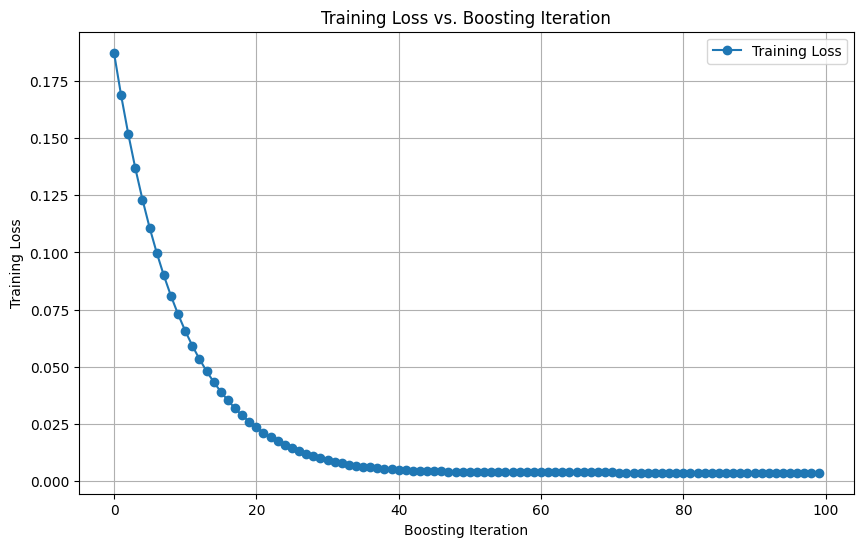

In [41]:

training_history = eval_callback.evaluation_results
training_loss = training_history[0]['train']['rmse']
# Extract the 'rmse' values from the training history
#rmse_values = [entry['train']['rmse'] for entry in training_history]
#training_loss = [value for sublist in rmse_values for value in sublist]





plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss', marker='o', linestyle='-')
plt.xlabel('Boosting Iteration')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Boosting Iteration')
plt.legend()
plt.grid()
plt.show()


In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
r_squared = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
sd_true = np.std(y_test)
rmse_sdr_ratio = reg_rmse / sd_true

print(f"MSE: {mse}")
print(f"R-squared (R²): {r_squared}")
print(f"MAE: {mae}")
print(f"RMSE/SDR ratio: {rmse_sdr_ratio}")

MSE: 9.330384281058453e-06
R-squared (R²): 0.9997716128849893
MAE: 0.0023219566395961603
RMSE/SDR ratio: 0.015112482092983381


2102401


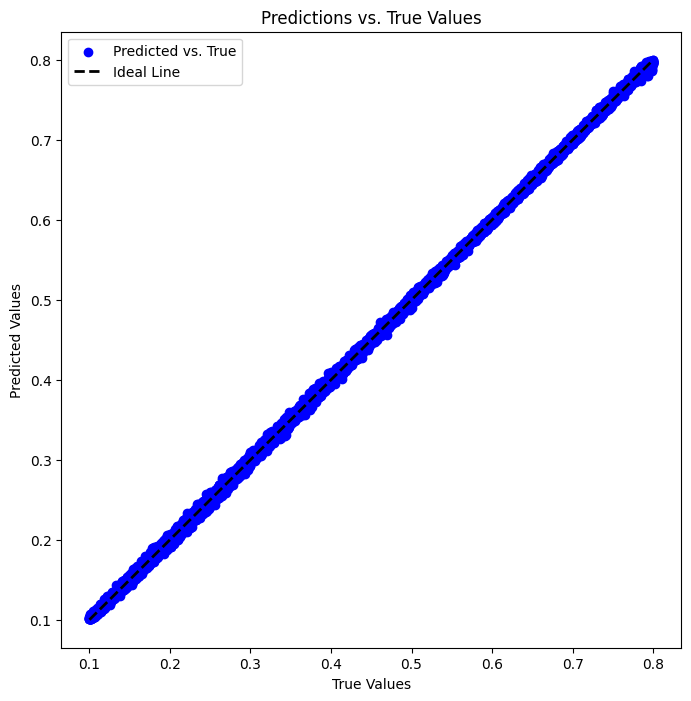

In [59]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test[0:11000], y_pred[0:11000], c='blue', marker='o', label='Predicted vs. True')
print(len(y_pred))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs. True Values')
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

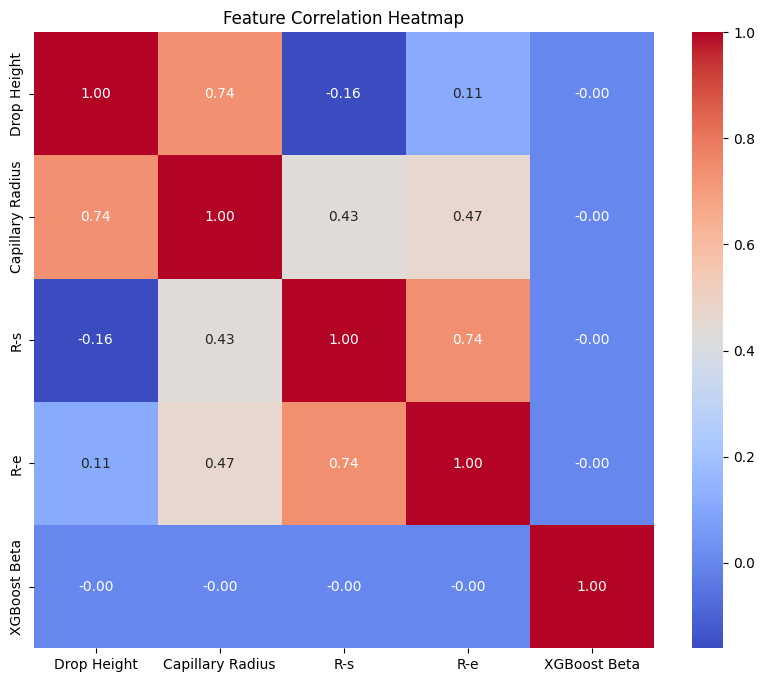

In [61]:
df_with_predictions = pd.concat([X_test, pd.Series(y_pred, name='XGBoost Beta')], axis=1)

feature_correlation = df_with_predictions.corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(feature_correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show

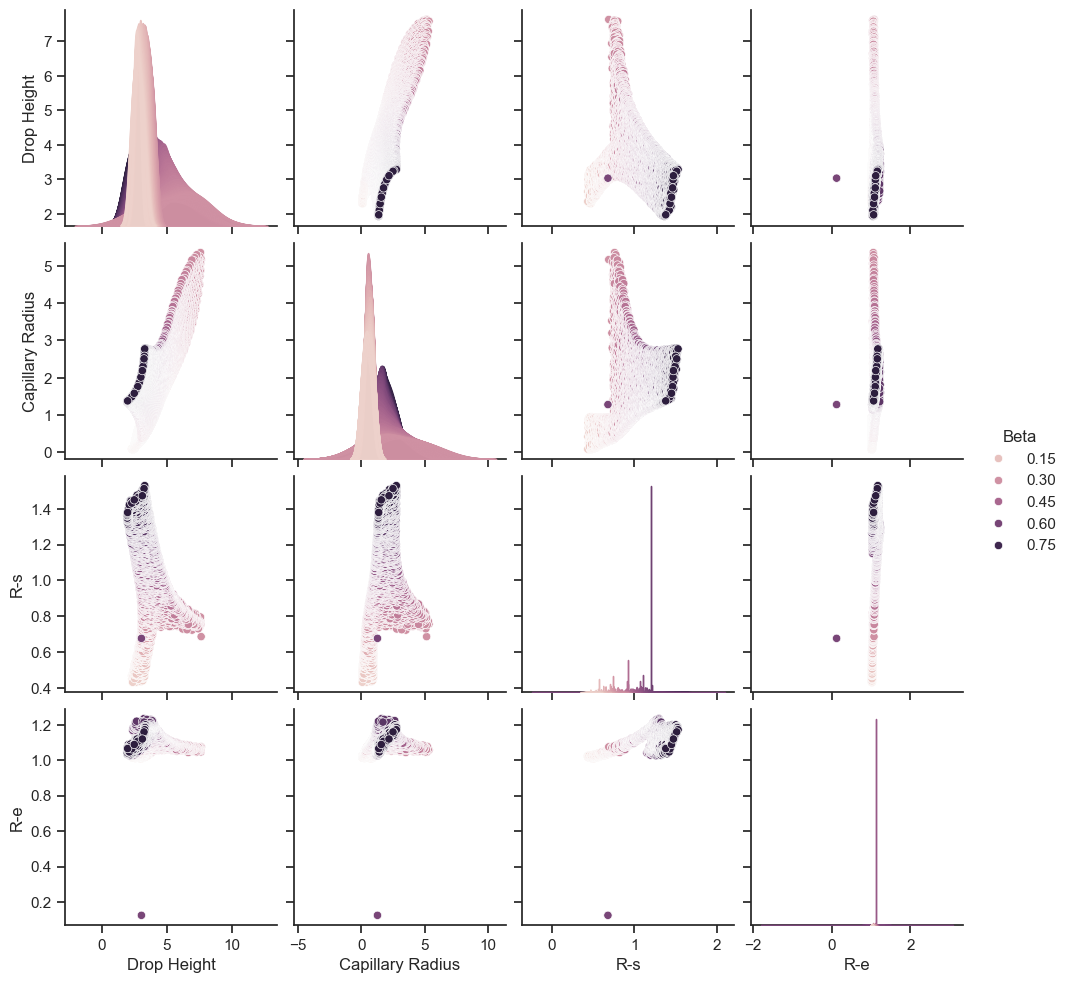

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

step_size = max(len(X_test) // 5000, 1)
first_row_df = df.iloc[::step_size]
first_row_df = first_row_df.reset_index(drop=True)

# Set the style for the plots
sns.set(style="ticks")

# Create a pair plot with KDEs
sns.pairplot(first_row_df, diag_kind="kde", markers="o", hue='Beta')

# "target_column" is the column containing the target variable. You can adjust it accordingly.

# Show the plot
plt.show()

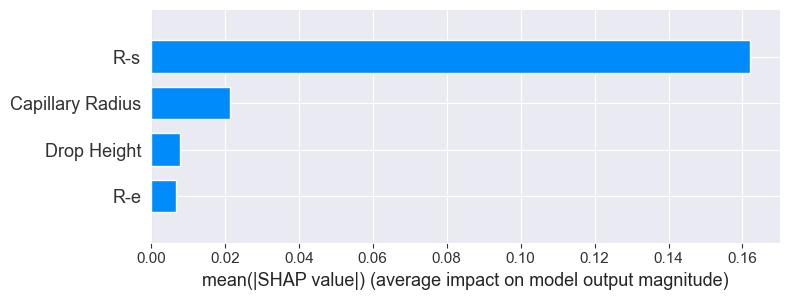

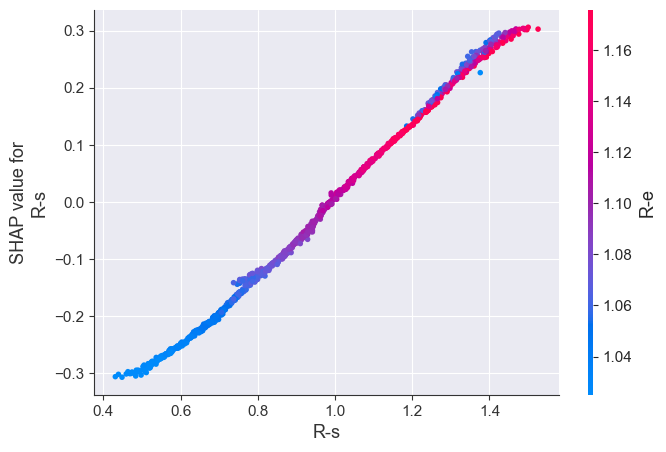

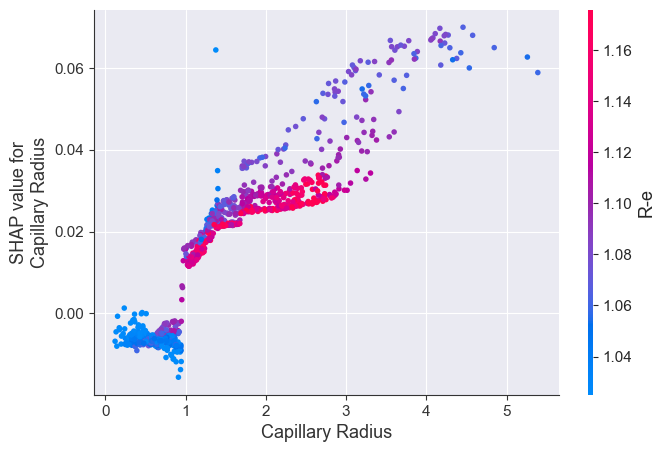

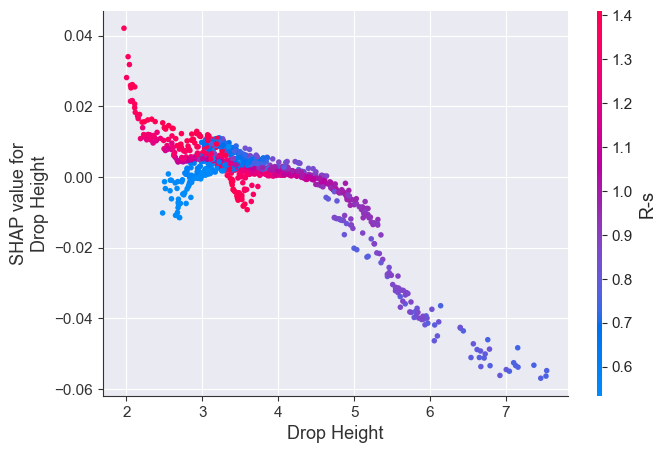

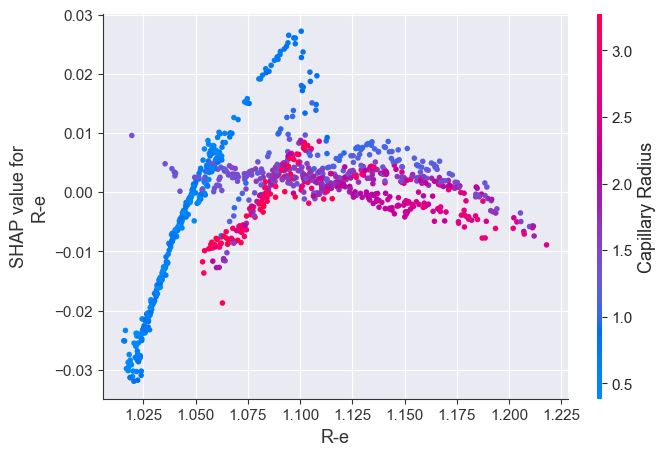

In [18]:
import shap
step_size = max(len(X_test) // 1000, 1)
first_row_df = X_test.iloc[::step_size]
first_row_df = first_row_df.reset_index(drop=True)
explainer = shap.TreeExplainer(xgb_wide)
shap_values = explainer.shap_values(first_row_df)
shap.initjs()
shap.summary_plot(shap_values, first_row_df, plot_type="bar")
shap.dependence_plot("R-s", shap_values, first_row_df )
shap.dependence_plot("Capillary Radius", shap_values, first_row_df )
shap.dependence_plot("Drop Height", shap_values, first_row_df )
shap.dependence_plot("R-e", shap_values, first_row_df )

# shap.force_plot(explainer.expected_value[1], shap_values[1], X_train.iloc[1])

### Build and Characterize a LightGBM Regressor Model for the same 3 datasets.

In [3]:
df = pd.read_csv('../data/pdt-dataset-wider-beta-no-Smax.csv').apply(lambda x: x*1000000).astype('int64')
df.head()

,Drop Height,Capillary Radius,R-s,R-e,Beta
0,2305560,98640,469920,1017619,100000
1,2322946,83864,460409,1017719,100000
2,2347761,78837,440249,1017397,100000
3,2372782,81146,454684,1019378,100000
4,2398734,91546,461319,1017129,100000


In [4]:
# This model predicts Beta given a Pendant Drop Profile
X = df.drop('Beta', axis=1)
y = df['Beta']

# Stratified fold includes the same percentage of target values in each fold.
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
y.head()

0    100000
1    100000
2    100000
3    100000
4    100000
Name: Beta, dtype: int64

In [5]:
# This function takes a list of hyperparameter configs and finds the best one.
def lgb_grid_search(params, random=False):
    # Initialize LightGBM Regressor with objective='reg:squarederror' (MSE)
    lgb_reg = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression',
    random_state=2)
    if random:
        grid = RandomizedSearchCV(lgb_reg, params, cv=kfold, n_iter=20, n_jobs=-1)
    else:
        grid = GridSearchCV(lgb_reg, params, cv=kfold, n_jobs=-1)
    grid.fit(X, y)
    best_params = grid.best_params_
    print("Best params:", best_params)
    best_score = grid.best_score_
    print("Training score: {:.3f}".format(best_score))

In [6]:
param_list = [
    {'learning_rate': [0.1, 0.01], 'max_depth': [3, 5]},
    {'learning_rate': [0.05, 0.01], 'max_depth': [4, 6]}
]
best_regressor = lgb_grid_search(param_list, False)

Best params: {'learning_rate': 0.1, 'max_depth': 5}
Training score: 1.000


In [7]:
param_list = {
    'num_leaves': [10, 20, 50],  # Maximum number of leaves in a tree
    'max_depth': [5, 10, 20],  # Maximum depth of a tree
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate for gradient boosting
    'n_estimators': [50, 100, 250],  # Number of trees to fit
    # 'subsample_for_bin': [20000, 50000, 100000],  # Number of samples for constructing bins
    'min_child_samples': [5, 10, 20],  # Minimum number of samples required to form a leaf node
    #'reg_alpha': [0, 0.1, 0.5, 1],  # L1 regularization
    #'reg_lambda': [0, 0.1, 0.5, 1],  # L2 regularization
    #'colsample_bytree': [0.5, 0.7, 1.0],  # Fraction of features to consider at each split
    #'subsample': [0.5, 0.7, 1.0],  # Fraction of samples to use for each tree
    #'min_split_gain': [0, 0.1, 0.5],  # Minimum loss reduction required to form a new split
    #'max_bin': [255, 511, 1023],  # Maximum number of bins to use
    'early_stopping_rounds': [None, 5, 10, 15],  # Early stopping based on the validation set score
}
best_regressor = lgb_grid_search(param_list, False)

Best params: {'early_stopping_rounds': None, 'learning_rate': 0.1, 'max_depth': 20, 'min_child_samples': 10, 'n_estimators': 250, 'num_leaves': 50}
Training score: 1.000


### Tuned LightGBM Model
* early_stopping_rounds=None
* learnging_rate=0.1
* max_depth=20
* min_child_samples=10
* n_estimators=250
* num_leaves=50

In [3]:
# Build, train, test, and save our LightGBM model
lgbm_reg = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression',
                            early_stopping_rounds=None,
                            learning_rate=0.101,
                            max_depth=12,
                            min_child_samples=10,
                            n_estimators=250,
                            num_leaves=50,
                            random_state=2)

df = pd.read_csv('../data/test/8-27-pdt-training-set.csv')

X = df.drop('Beta', axis=1)
y = df['Beta']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

lgbm_reg.fit(X_train, y_train)

y_pred = lgbm_reg.predict(X_test)

reg_mse = mean_squared_error(y_test, y_pred)
reg_rmse = np.sqrt(reg_mse)
print(f"RMSE: {reg_rmse}")
# print(lgbm_reg.feature_importances_)
norm_mean = reg_rmse / np.mean(y)
print(f"Normalized Mean {norm_mean}")

# Save our previous model to models folder
with open("../models/lightgbm-wide-beta-tuned-model.pkl", 'wb') as f:
    pickle.dump(lgbm_reg, f)

RMSE: 0.003157846528900123
Normalized Mean 0.007017436730889153


In [18]:
features_sample = pd.read_csv("../data/Feature Sets/features.csv")

features = features_sample.values
xgb_beta  = xgb_wide.predict(features)
lgbm_beta = lgbm_reg.predict(features)

print(f"XGBoost Prediction: {xgb_beta}")
print(f"LightGBM Prediction: {lgbm_beta}")

XGBoost Prediction: [0.5259061]
LightGBM Prediction: [0.50138153]


In [4]:
df = pd.read_csv('../data/features.csv')
features = df.drop('image', axis=1)
features = features.drop('Apex Radius', axis=1)
images = df['image']

features = features.values
xgb_beta  = xgb_wide.predict(features)
lgbm_beta = lgbm_reg.predict(features)
# Create empty columns for predictions in the dataset
#df['XGBoost_Prediction'] = ''
#df['LightGBM_Prediction'] = ''
print(xgb_beta)
print(lgbm_beta)

df['XGBoost Prediction'] = xgb_beta
df['LightGBM Prediction'] = lgbm_beta

df.to_csv('../data/test/8-26-features-predictions.csv')

[0.51990193 0.5152647  0.5210587  0.5234555  0.52336454 0.5181193
 0.51522154 0.5176837  0.52403855 0.5109968  0.511735   0.5115698
 0.5153256  0.5145013 ]
[0.51409535 0.51981986 0.52169133 0.52557961 0.52557961 0.51685131
 0.51936875 0.51969252 0.52267232 0.51376672 0.51407498 0.51623299
 0.51936875 0.51315837]
